# Multisensor rail detection in automatic train operations - Test different evaluation metrics
Attila Kovacs
25.11.2023


## Introduction

In this notebeook, we will test different evaluation metrics for our problem and select the ones that are most applicable.


In [127]:
from metrics import BinaryMetrics
import torch
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import os
import seaborn as sns
import numpy as np

from utils import generate_mask_path, generate_mask_df

## For each image we are given the labels and can extract a mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


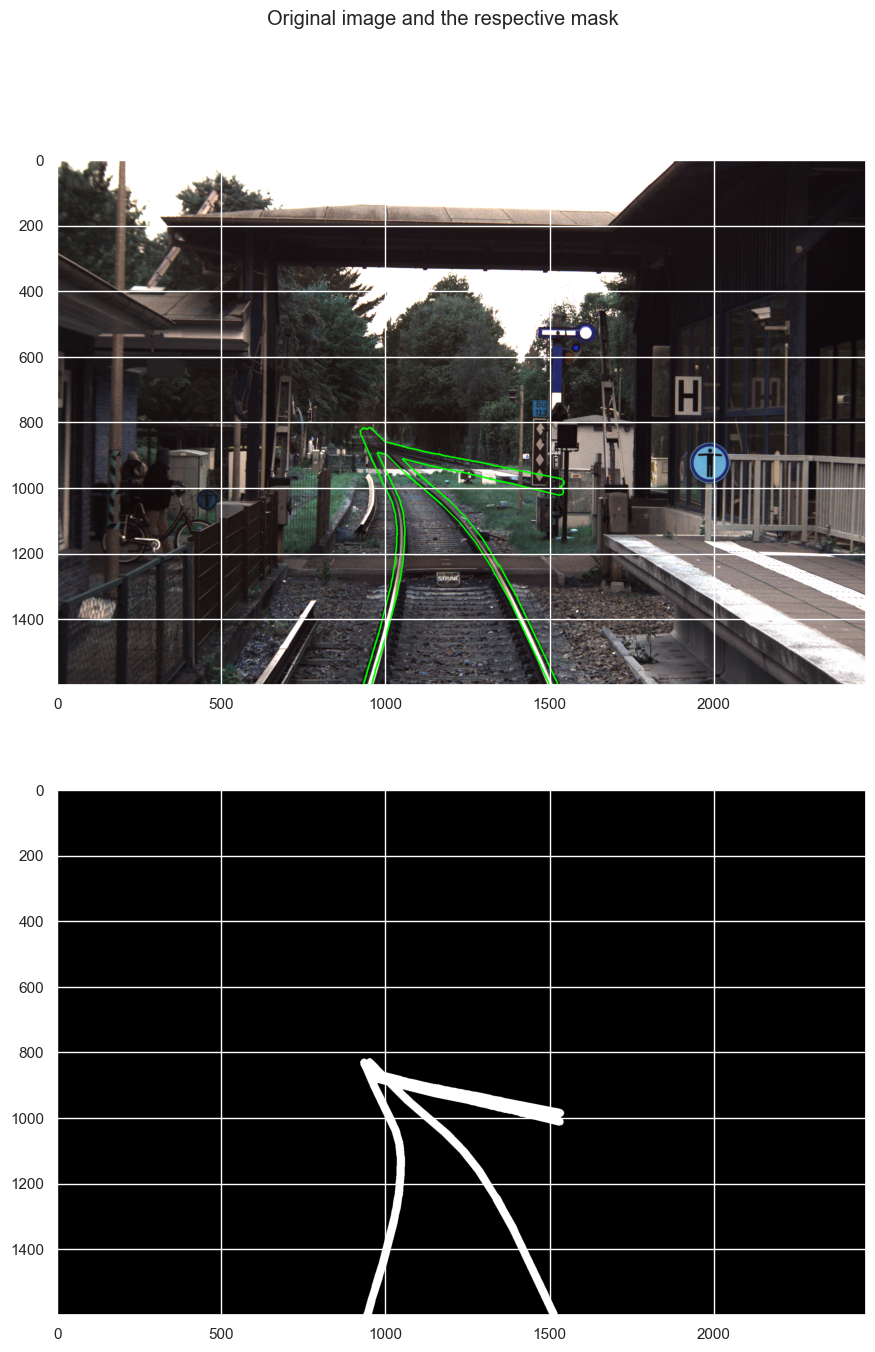

In [128]:
path_image = "../rail_detection/datasets/data_rgb/train/images/10_station_suelldorf_10.1_rgb_center_216_1631703820.700000000.png"
path_label = "../rail_detection/datasets/data_rgb/train/labels/10_station_suelldorf_10.1_rgb_center_216_1631703820.700000000.txt"
mask = generate_mask_path(path_image=path_image, path_label=path_label, print=True)

## Select one target and five predictions randomly from existing set of images

In [129]:
df = pd.read_json(max(glob("./dataframe_dumps/df_eda_*"), key=os.path.getmtime))
df = df[df["sensor"] == "rgb_highres_center"]

C:\Users\atkovacs\AppData\Local\Temp\ipykernel_18536\5639941.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df = pd.read_json(max(glob("./dataframe_dumps/df_eda_*"), key=os.path.getmtime))


12_vegetation_steady_12.1/rgb_highres_center/038_1631177223.900000015.png


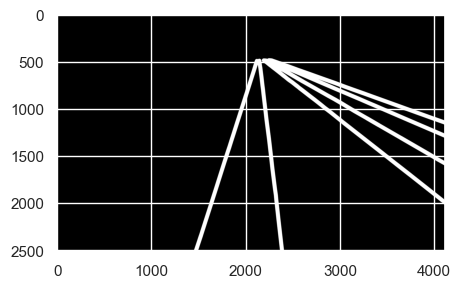

In [161]:
target = df.sample(1)

pred = []
for i in range(5):
    pred.append(df.sample(1))

target_mask = (
    cv2.cvtColor(
        generate_mask_df(df, file=target.path.values[0], path="./orig_data/DB/"),
        cv2.COLOR_BGR2GRAY,
    )
    / 255
)

# targt
sns.set(rc={"figure.figsize": (5, 5)})
plt.imshow(target_mask, cmap="grey")

16_under_bridge_16.1/rgb_highres_center/449_1631525771.000000025.png
2_station_berliner_tor_2.1/rgb_highres_center/258_1631531385.900000007.png
13_station_ohlsdorf_13.1/rgb_highres_center/072_1631176103.300000030.png
4_station_pedestrian_bridge_4.3/rgb_highres_center/093_1631704343.400000024.png
12_vegetation_steady_12.1/rgb_highres_center/071_1631177227.200000009.png
(2504, 4112)
(2504, 4112)
(2504, 4112)
(2504, 4112)
(2504, 4112)
(2504, 4112)


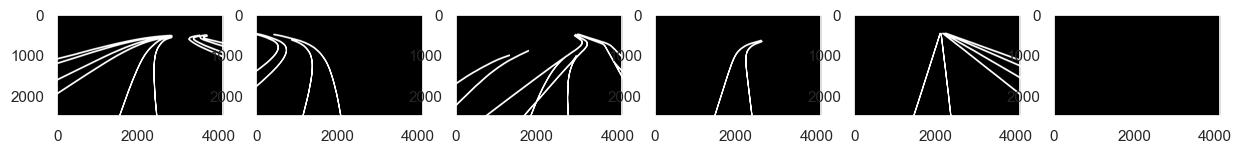

In [131]:
# five random predictions

pred_mask = []
for i in range(len(pred)):
    pred_mask.append(
        cv2.cvtColor(
            generate_mask_df(df, file=pred[i].path.values[0], path="./orig_data/DB/"),
            cv2.COLOR_BGR2GRAY,
        )
        / 255
    )


pred_mask.append(np.zeros_like(target_mask).astype(np.float32))

sns.set(rc={"figure.figsize": (15, 15)})


fig, ax = plt.subplots(1, len(pred_mask))
for i in range(len(pred_mask)):
    print(pred_mask[i].shape)
    ax[i].grid(None)
    ax[i].imshow(pred_mask[i], cmap="grey")

## Comapre target with each prediction

In [162]:
transform = transforms.Compose([transforms.ToTensor()])
target_tensor = transform(target_mask)
target_tensor = target_tensor[None, :]
target_tensor.shape

torch.Size([1, 1, 2504, 4112])

In [163]:
pred_tensor = []
for i in range(len(pred_mask)):
    tmp = transform(pred_mask[i])
    pred_tensor.append(tmp[None, :])
    print(pred_tensor[-1].shape)

torch.Size([1, 1, 2504, 4112])
torch.Size([1, 1, 2504, 4112])
torch.Size([1, 1, 2504, 4112])
torch.Size([1, 1, 2504, 4112])
torch.Size([1, 1, 2504, 4112])
torch.Size([1, 1, 2504, 4112])


In [164]:
bm = BinaryMetrics()

In [165]:
results = []
for i in range(len(pred_tensor)):
    pixel_acc, dice, precision, specificity, recall, f1_score, iou = bm(
        y_pred=pred_tensor[i], y_true=target_tensor
    )


    tmp = {
        "pixel_acc": pixel_acc.numpy(),
        "dice": dice.numpy(),
        "precision": precision.numpy(),
        "specificity": specificity.numpy(),
        "recall": recall.numpy(),

        "f1_score": f1_score.numpy(),
        "iou": iou.numpy(),

    }
    results.append(tmp)

The best evaluation metric seems to be dice as it is most sensitive to good vs bad predictions. Note that f1 is the same as dice. However, do to different implementation and numerical instability the values can deviate.
Precision and specificity seems to be best with the completely black image. The lack of positive predictions leades to a division by zero, so we end up dividing a small value by a small value in the implementation. 

In [166]:
df_res = pd.DataFrame(results)
df_res

,pixel_acc,dice,precision,specificity,recall,f1_score,iou
0,0.88156927,0.0863909,0.072025724,0.9239095,0.10791375,0.08644166,0.04514553
1,0.91334313,0.0068343873,0.008430869,0.96301365,0.005746266,0.0075344346,0.0034289109
2,0.89040977,0.059812896,0.053900193,0.93546295,0.067182645,0.059890535,0.030828416
3,0.95550513,0.36506712,0.7032115,0.9943059,0.24652417,0.36507383,0.2232918
4,0.9993604,0.9938373,0.9936811,0.99965405,0.9939936,0.9938373,0.9877501
5,0.9481122,1.8717477e-11,1.0,1.0,1.8717477e-11,9.999937e-06,1.8717477e-11
